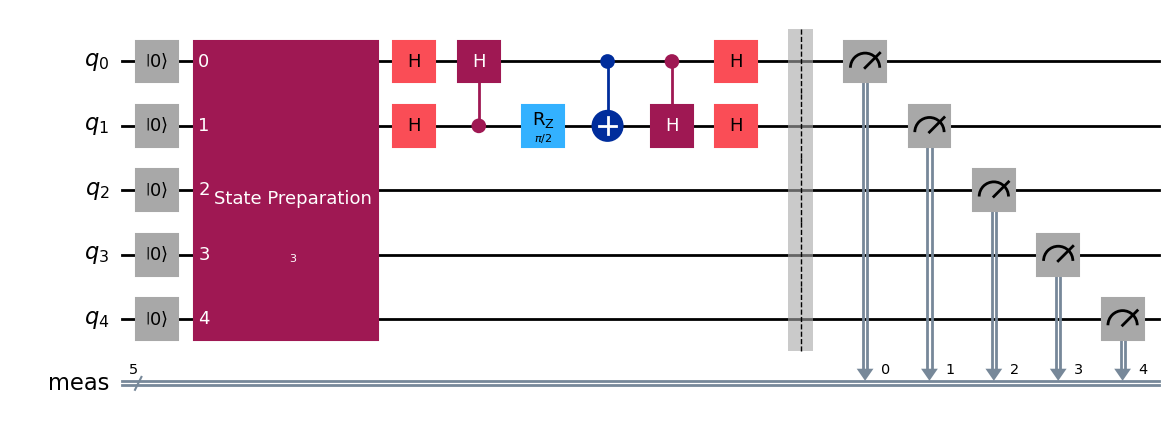

In [35]:

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
from qiskit.primitives import Sampler
import pandas as pd

size = 5

qreg_q = QuantumRegister(size, 'q')
creg_c = ClassicalRegister(size, 'c')
circuit = QuantumCircuit(qreg_q)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.ch(qreg_q[1], qreg_q[0])
circuit.rz(np.pi/2, qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ch(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])


tests = range(1,int(2**size))

circuit_list = []

for test in tests:
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list += [circuit_sampler]
    
display(circuit_list[0].decompose().draw())

    

In [75]:
    
sampler = Sampler()
job = sampler.run(circuit_list,shots = 2000)
result = job.result()
df = pd.DataFrame(list(enumerate(result.quasi_dists,1)))
df.set_index(0, inplace=True)

df = df[1].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 1, 1: "one"})
df[1] = df[1].astype(int)
df.set_index(1, append=True, inplace=True)

tree = df.loc[[1]]
tree["weight"] = tree["one"]
tree = tree["weight"].to_frame()
tree["leaf"] = tree.index.get_level_values(1)
tree.index = tree.index.to_flat_index()
dft = tree[["weight","leaf"]]


for i in range(2,4):
    dft = dft[["weight","leaf"]]
    tree_list = []

    for test in list(dft.leaf.to_list()):
        circuit_sampler = QuantumCircuit(qreg_q)
        circuit_sampler.initialize(test)
        circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
        circuit_sampler.measure_all()
        tree_list += [circuit_sampler]

    job_tree = sampler.run(tree_list,shots = 2000).result()

    dft["weight"] = pd.DataFrame(list(enumerate(job_tree.quasi_dists,1)))[1].values

    dft = dft["weight"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: i, 1: "weight"})

    dft[i] = dft[i].astype(int)
    dft.set_index(i, append=True, inplace=True)
    dft["leaf"] = dft.index.get_level_values(1)
    dft.index = dft.index.to_flat_index()
    tree = pd.concat([tree,dft])
    
tree["leaf"] = tree.index.values

tree["parent"] = pd.Series(list(zip(*tree.leaf))[0]).values

tree

,weight,leaf,parent
"(1, 0)",0.3105,"(1, 0)",1
"(1, 1)",0.3205,"(1, 1)",1
"(1, 2)",0.0100,"(1, 2)",1
"(1, 3)",0.3590,"(1, 3)",1
"((1, 0), 0)",0.1870,"((1, 0), 0)","(1, 0)"
...,...,...,...
"(((1, 3), 2), 3)",0.1335,"(((1, 3), 2), 3)","((1, 3), 2)"
"(((1, 3), 3), 0)",0.3150,"(((1, 3), 3), 0)","((1, 3), 3)"
"(((1, 3), 3), 1)",0.3110,"(((1, 3), 3), 1)","((1, 3), 3)"
"(((1, 3), 3), 2)",0.0105,"(((1, 3), 3), 2)","((1, 3), 3)"


In [47]:


circuit_list_two = []

for test in list(df.index.get_level_values(1)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_two += [circuit_sampler]
    
job_two = sampler.run(circuit_list_two,shots = 2000).result()

df["two"] = pd.DataFrame(list(enumerate(job_two.quasi_dists,1)))[1].values

#display(df)

dft = df["two"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 2, 1: "two"})
df = df["one"].to_frame().join(dft)
df[2] = df[2].astype(int)
df.set_index(2, append=True, inplace=True)

circuit_list_three = []

for test in list(df.index.get_level_values(2)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_three += [circuit_sampler]
    
job_three = sampler.run(circuit_list_three,shots = 2000).result()

df["three"] = pd.DataFrame(list(enumerate(job_three.quasi_dists,1)))[1].values

#display(df)

dft = df["three"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 3, 1: "three"})
df = df[["one","two"]].join(dft)
df[3] = df[3].astype(int)
df.set_index(3, append=True, inplace=True)

df.index.to_flat_index()

,one,leaf
"(1, 0)",0.3095,0
"(1, 1)",0.3110,1
"(1, 2)",0.0085,2
"(1, 3)",0.3710,3


Index([    (1, 0, 0, 0),     (1, 0, 0, 1),     (1, 0, 0, 2),     (1, 0, 0, 3),
           (1, 0, 1, 0),     (1, 0, 1, 1),     (1, 0, 1, 2),     (1, 0, 1, 3),
           (1, 0, 2, 0),     (1, 0, 2, 1),
       ...
       (31, 31, 29, 30), (31, 31, 29, 31), (31, 31, 30, 28), (31, 31, 30, 29),
       (31, 31, 30, 30), (31, 31, 30, 31), (31, 31, 31, 28), (31, 31, 31, 29),
       (31, 31, 31, 30), (31, 31, 31, 31)],
      dtype='object', length=1984)

In [ ]:


df["probs"] = (df["one"]) + (df["two"]) + (df["three"])

df.head(50)

In [ ]:
df.groupby(level=[0])["probs"].nlargest(1).droplevel([0,1,2])